In [21]:
# Import necessary dependencies
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCols
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import DataFrame
from pyspark import keyword_only
from pyspark.ml.regression import (
    LinearRegression,
    GBTRegressor,
    LinearRegressionModel,
    GBTRegressionModel,
)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
import os

### Connect to Hive & Read Hive Tables

In [22]:
print("Current working directory:", os.getcwd())

Current working directory: /home/team31/project/bigdata-final-project/notebooks


In [23]:
# Add here your team number teamx
team = 31

# location of your Hive database in HDFS
warehouse = "project/hive/warehouse"

spark = SparkSession.builder\
        .appName("{} - spark ML".format(team))\
        .master("yarn")\
        .config("hive.metastore.uris",
                "thrift://hadoop-02.uni.innopolis.ru:9883")\
        .config("spark.sql.warehouse.dir", warehouse)\
        .config("spark.sql.avro.compression.codec", "snappy")\
        .enableHiveSupport()\
        .getOrCreate()

# List all tables
spark.sql("USE team31_projectdb").show()
spark.sql("SHOW TABLES").show()

++
||
++
++

+----------------+--------------------+-----------+
|       namespace|           tableName|isTemporary|
+----------------+--------------------+-----------+
|team31_projectdb|model1_feature_im...|      false|
|team31_projectdb|  model1_predictions|      false|
|team31_projectdb|model2_feature_im...|      false|
|team31_projectdb|  model2_predictions|      false|
|team31_projectdb|          q1_results|      false|
|team31_projectdb|          q2_results|      false|
|team31_projectdb|          q3_results|      false|
|team31_projectdb|          q4_results|      false|
|team31_projectdb|          q5_results|      false|
|team31_projectdb|          q6_results|      false|
|team31_projectdb|          q7_results|      false|
|team31_projectdb|          q8_results|      false|
|team31_projectdb|          taxi_zones|      false|
|team31_projectdb|               trips|      false|
|team31_projectdb|          trips_part|      false|
|team31_projectdb|             weather|      false|

In [25]:
spark.read.format("avro").table("team31_projectdb.model1_predictions").limit(10).show()

+----------+------------------+---+
|driver_pay|   driver_pay_pred| id|
+----------+------------------+---+
|      9.91| 9.785531537862484|  0|
|     32.81|30.339978788570058|  1|
|     15.22|14.693795418815146|  2|
|     15.22|14.693795418815146|  3|
|      6.71| 4.937530417587425|  4|
|     24.89|19.587252448191414|  5|
|      7.67| 8.327461967814564|  6|
|      6.58| 4.997501695598027|  7|
|      6.97| 7.247045113907487|  8|
|     10.22| 9.724604750504682|  9|
+----------+------------------+---+



In [4]:
# Read all main Hive tables
taxi_zones = spark.read.format("avro").table('team31_projectdb.taxi_zones')
trips = spark.read.format("avro").table('team31_projectdb.trips')
trips_part = spark.read.format("avro").table('team31_projectdb.trips_part')
weather = spark.read.format("avro").table('team31_projectdb.weather')

In [5]:
# Take a look at the dataframes' schemas
print("Taxi zones:")
taxi_zones.printSchema()

print("Trips:")
trips.printSchema()

print("Trips partitioned:")
trips_part.printSchema()

print("Weather:")
weather.printSchema()

Taxi zones:
root
 |-- location_id: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- service_zone: string (nullable = true)

Trips:
root
 |-- trip_id: long (nullable = true)
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: long (nullable = true)
 |-- on_scene_datetime: long (nullable = true)
 |-- pickup_datetime: long (nullable = true)
 |-- dropoff_datetime: long (nullable = true)
 |-- pu_location_id: integer (nullable = true)
 |-- do_location_id: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: integer (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = tr

#### Take a look at all the first few rows of each dataframe

In [6]:
# Print shapes of all dataframes
# Apparently, we will use "trips_part" instead of "trips"
print(f"Taxi zones: {taxi_zones.count()}")
print(f"Trips: {trips.count()}")
print(f"Trips partitioned: {trips_part.count()}")
print(f"Weather: {weather.count()}")

Taxi zones: 265
Trips: 2450668
Trips partitioned: 2450668
Weather: 365


In [7]:
spark.sql("""
    SELECT * FROM taxi_zones LIMIT 10;
""").show()

+-----------+-------------+--------------------+------------+
|location_id|      borough|                zone|service_zone|
+-----------+-------------+--------------------+------------+
|          1|          EWR|      Newark Airport|         EWR|
|          2|       Queens|         Jamaica Bay|   Boro Zone|
|          3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|          4|    Manhattan|       Alphabet City| Yellow Zone|
|          5|Staten Island|       Arden Heights|   Boro Zone|
|          6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|          7|       Queens|             Astoria|   Boro Zone|
|          8|       Queens|        Astoria Park|   Boro Zone|
|          9|       Queens|          Auburndale|   Boro Zone|
|         10|       Queens|        Baisley Park|   Boro Zone|
+-----------+-------------+--------------------+------------+



In [8]:
taxi_zones.limit(10)

DataFrame[location_id: int, borough: string, zone: string, service_zone: string]

In [9]:
# We won't use this table but let's take a look at it anyway
spark.sql("""
    SELECT * FROM trips LIMIT 1;
""").show(vertical=True, truncate=False)

-RECORD 0-----------------------------
 trip_id              | 1             
 hvfhs_license_num    | HV0003        
 dispatching_base_num | B02682        
 originating_base_num | B02682        
 request_datetime     | 1609450089000 
 on_scene_datetime    | 1609450302000 
 pickup_datetime      | 1609450424000 
 dropoff_datetime     | 1609451347000 
 pu_location_id       | 230           
 do_location_id       | 166           
 trip_miles           | 5.26          
 trip_time            | 923           
 base_passenger_fare  | 22.28         
 tolls                | 0.0           
 bcf                  | 0.67          
 sales_tax            | 1.98          
 congestion_surcharge | 2.75          
 airport_fee          | null          
 tips                 | 0.0           
 driver_pay           | 14.99         
 shared_request_flag  | N             
 shared_match_flag    | N             
 wav_request_flag     | N             
 wav_match_flag       | N             
 request_date         | 1

In [10]:
spark.sql("""
    SELECT * FROM trips_part LIMIT 1;
""").show(vertical=True, truncate=False)

-RECORD 0-----------------------------
 trip_id              | 2449218       
 hvfhs_license_num    | HV0003        
 originating_base_num | B02877        
 request_datetime     | 1610077693000 
 on_scene_datetime    | 1610077812000 
 pickup_datetime      | 1610077934000 
 dropoff_datetime     | 1610078383000 
 pu_location_id       | 168           
 do_location_id       | 168           
 trip_miles           | 1.48          
 trip_time            | 449           
 base_passenger_fare  | 8.39          
 tolls                | 0.0           
 bcf                  | 0.25          
 sales_tax            | 0.74          
 congestion_surcharge | 0.0           
 airport_fee          | null          
 tips                 | 0.0           
 driver_pay           | 5.42          
 shared_request_flag  | N             
 shared_match_flag    | N             
 wav_request_flag     | N             
 wav_match_flag       | N             
 request_date         | 1610053200000 
 request_time         | 1

In [11]:
spark.sql("""
    SELECT * FROM weather LIMIT 1;
""").show(vertical=True, truncate=False)

-RECORD 0-----------------------------------------
 station_name       | nyc                         
 station_address    | nyc                         
 resolved_address   | New York, NY, United States 
 date_id            | 1609448400000               
 temperature        | 2.5                         
 feels_like         | -0.2                        
 dew_point          | -3.0                        
 humidity           | 67.8                        
 precipitation      | 15.33                       
 precipitation_prob | 100                         
 precipitation_type | rain                        
 snow               | 0.0                         
 snow_depth         | 0.0                         
 wind_gust          | null                        
 wind_speed         | 15.5                        
 wind_direction     | 69.8                        
 sea_level_pressure | 1028.9                      
 cloud_cover        | 50.6                        
 visibility         | 14.0     

### Data Preprocessing

#### Notes:

- As we can see, we only have a weather data about one city - New York;
- Moreover, we have a daily data about weather in the city - 365 entries - for one year;
- Thus, we may use time features from our "trips_part" dataset to join these dataframes together;
- Since we may have multiple trips happen in the same day during the same weather, we may omit all the columns from the "weather" dataframe and use its index instead (ordinal encoding). Why? - If we do not do it, we will have multiple repeating column values for multiple rows. So, we can combine all weather columns in one singe column - index (e.g. from 0 to 364);
- Additionally, we have "taxi_zones" dataframe. We may join this dataframe and encode all the zones.

In [12]:
# Remove an unnecessary table/View
del trips

In [13]:
# Ensure that we have only one weather station
weather.select("station_name", "station_address", "resolved_address").distinct().show()

+------------+---------------+--------------------+
|station_name|station_address|    resolved_address|
+------------+---------------+--------------------+
|         nyc|            nyc|New York, NY, Uni...|
+------------+---------------+--------------------+



In [14]:
# Check the amount of NULL values in our dataframes
trips_part.select(
    [
        F.count(
            F.when(F.col(c).isNull(), c)
        ).alias(c) for c in trips_part.columns
    ]
).show(vertical=True, truncate=False)

taxi_zones.select(
    [
        F.count(
            F.when(F.col(c).isNull(), c)
        ).alias(c) for c in taxi_zones.columns
    ]
).show(vertical=True, truncate=False)

weather.select(
    [
        F.count(
            F.when(F.col(c).isNull(), c)
        ).alias(c) for c in weather.columns
    ]
).show(vertical=True, truncate=False)

-RECORD 0-----------------------
 trip_id              | 0       
 hvfhs_license_num    | 0       
 originating_base_num | 674478  
 request_datetime     | 0       
 on_scene_datetime    | 673284  
 pickup_datetime      | 0       
 dropoff_datetime     | 0       
 pu_location_id       | 0       
 do_location_id       | 0       
 trip_miles           | 0       
 trip_time            | 0       
 base_passenger_fare  | 0       
 tolls                | 0       
 bcf                  | 0       
 sales_tax            | 0       
 congestion_surcharge | 0       
 airport_fee          | 2449696 
 tips                 | 0       
 driver_pay           | 0       
 shared_request_flag  | 0       
 shared_match_flag    | 0       
 wav_request_flag     | 0       
 wav_match_flag       | 0       
 request_date         | 0       
 request_time         | 0       
 dispatching_base_num | 0       

-RECORD 0-----------
 location_id  | 0   
 borough      | 0   
 zone         | 0   
 service_zone | 0   

-R

#### Regarding the NULL values

- "trips_part":
    * We will not need "originating_base_num" because we will use "pu_location_id" and "do_location_id";
    * We will not need "on_scene_datetime" as well as "pickup_datetime"/"dropoff_datetime" because all these timestamps indicate one day. Thus, we can extract this information from "request_datetime";
    * We will drop "airport_fee" due to large amount of missing values.
- "weather":
    * We can drop "precipitation_type", "wind_fust", and "severe_risk" due to substantial amount of missing values.

In [15]:
# Drop columns with missing values
trips_part = trips_part.drop("originating_base_num", "on_scene_datetime",
                             "airport_fee")
weather = weather.drop("precipitation_type", "wind_gust", "severe_risk")

#### Extract "day" and "month" from the timestamps

In [16]:
# Ensure that it has an integer date type
type(trips_part.select("pickup_datetime")
     .limit(10)
     .collect()[0]
     .pickup_datetime)

int

In [17]:
# Parse "day", "month", "day_month" columns
trips_part = trips_part.withColumn(
    "date", F.from_unixtime("pickup_datetime").cast("timestamp")
).withColumn(
    "day", F.dayofmonth("date")
).withColumn(
    "month", F.month("date")
)

trips_part.select("date", "day", "month").limit(10).show()

+--------------------+---+-----+
|                date|day|month|
+--------------------+---+-----+
|+52991-04-28 09:5...| 28|    4|
|+52991-04-11 21:3...| 11|    4|
|+52991-04-10 21:2...| 10|    4|
|+52991-03-30 16:3...| 30|    3|
|+52991-04-05 21:5...|  5|    4|
|+52991-05-08 02:1...|  8|    5|
|+52991-05-01 11:3...|  1|    5|
|+52991-04-27 21:2...| 27|    4|
|+52991-05-06 23:1...|  6|    5|
|+52991-05-09 10:2...|  9|    5|
+--------------------+---+-----+



In [18]:
# Ensure the proper data type
type(weather.select("date_id").limit(10).collect()[0].date_id)

int

In [19]:
# Do the same with the "weather" dataframe
weather = weather.withColumn(
    "date_w", F.from_unixtime("date_id").cast("timestamp")
).withColumn(
    "day_w", F.dayofmonth("date_w")
).withColumn(
    "month_w", F.month("date_w")
)

weather.select("date_w", "day_w", "month_w").limit(10).show()

+--------------------+-----+-------+
|              date_w|day_w|month_w|
+--------------------+-----+-------+
|+52971-05-23 03:0...|   23|      5|
|+52974-02-16 03:0...|   16|      2|
|+52976-11-12 03:0...|   12|     11|
|+52979-08-09 03:0...|    9|      8|
|+52982-05-05 03:0...|    5|      5|
|+52985-01-29 03:0...|   29|      1|
|+52987-10-26 03:0...|   26|     10|
|+52990-07-22 03:0...|   22|      7|
|+52993-04-17 03:0...|   17|      4|
|+52996-01-12 03:0...|   12|      1|
+--------------------+-----+-------+



In [20]:
# Join "trips_part" and "weather" on "day_month"
# And drop unnecesary date columns (with "_w")
combined_df = trips_part.join(
    F.broadcast(weather),
    (trips_part["day"] == weather["day_w"]) &
    (trips_part["month"] == weather["month_w"]),
    "inner",
).drop("date_w", "day_w", "month_w")

combined_df.limit(1).show(vertical=True, truncate=False)

-RECORD 0-------------------------------------------
 trip_id              | 2262639                     
 hvfhs_license_num    | HV0004                      
 request_datetime     | 1610022694000               
 pickup_datetime      | 1610023359000               
 dropoff_datetime     | 1610024209000               
 pu_location_id       | 74                          
 do_location_id       | 262                         
 trip_miles           | 2.29                        
 trip_time            | 849                         
 base_passenger_fare  | 12.95                       
 tolls                | 0.0                         
 bcf                  | 0.0                         
 sales_tax            | 0.92                        
 congestion_surcharge | 2.75                        
 tips                 | 0.0                         
 driver_pay           | 0.0                         
 shared_request_flag  | N                           
 shared_match_flag    | N                     

#### Add taxi zones data to our combined dataframe

In [21]:
taxi_zones.limit(10).show()

+-----------+-------------+--------------------+------------+
|location_id|      borough|                zone|service_zone|
+-----------+-------------+--------------------+------------+
|          1|          EWR|      Newark Airport|         EWR|
|          2|       Queens|         Jamaica Bay|   Boro Zone|
|          3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|          4|    Manhattan|       Alphabet City| Yellow Zone|
|          5|Staten Island|       Arden Heights|   Boro Zone|
|          6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|          7|       Queens|             Astoria|   Boro Zone|
|          8|       Queens|        Astoria Park|   Boro Zone|
|          9|       Queens|          Auburndale|   Boro Zone|
|         10|       Queens|        Baisley Park|   Boro Zone|
+-----------+-------------+--------------------+------------+



In [22]:
# Calculate the amount of unique values in each column
print(f'borough: {taxi_zones.select("borough").distinct().count()}')
print(f'zone: {taxi_zones.select("zone").distinct().count()}')
print(f'service_zone: {taxi_zones.select("service_zone").distinct().count()}')

borough: 7
zone: 262
service_zone: 5


In [23]:
taxi_zones.columns

['location_id', 'borough', 'zone', 'service_zone']

In [24]:
# Calculate the amount of each unique value in "taxi_zones"
for col in taxi_zones.columns[1:]:
    print(f"\nValue counts for {col}:")
    taxi_zones.groupBy(col).count().orderBy(F.desc("count")).show(truncate=False)


Value counts for borough:
+-------------+-----+
|borough      |count|
+-------------+-----+
|Manhattan    |69   |
|Queens       |69   |
|Brooklyn     |61   |
|Bronx        |43   |
|Staten Island|20   |
|Unknown      |2    |
|EWR          |1    |
+-------------+-----+


Value counts for zone:
+---------------------------------------------+-----+
|zone                                         |count|
+---------------------------------------------+-----+
|Governor's Island/Ellis Island/Liberty Island|3    |
|Corona                                       |2    |
|Homecrest                                    |1    |
|Bensonhurst West                             |1    |
|Newark Airport                               |1    |
|Douglaston                                   |1    |
|Westerleigh                                  |1    |
|Marble Hill                                  |1    |
|Charleston/Tottenville                       |1    |
|Upper East Side South                        |1    |
|Eas

As you can see, almost all the values in "zone" column are unique. That is why we can drop this column.

In [25]:
# Drop "zone" column
taxi_zones = taxi_zones.drop("zone")
taxi_zones.columns

['location_id', 'borough', 'service_zone']

In [26]:
# Encode categorical values
# We will stick with One-Hot Encoding for these 2 columns
# Define our taxi_zone_encode_pipeline
taxi_zone_encode_pipeline = Pipeline(
    stages=[
        StringIndexer(
            inputCol="borough",
            outputCol="borough_indexed",
            handleInvalid="keep",
        ),
        OneHotEncoder(
            inputCol="borough_indexed",
            outputCol="borough_encoded",
            dropLast=False,
        ),
        StringIndexer(
            inputCol="service_zone",
            outputCol="service_zone_indexed",
            handleInvalid="keep",
        ),
        OneHotEncoder(
            inputCol="service_zone_indexed",
            outputCol="service_zone_encoded",
            dropLast=False,
        )
    ]
)

In [27]:
# Fit our pipeline
taxi_zone_encoder = taxi_zone_encode_pipeline.fit(taxi_zones)
taxi_zone_encoded = taxi_zone_encoder.transform(taxi_zones).drop(
    "borough",
    "service_zone",
    "borough_indexed",
    "service_zone_indexed"
)

taxi_zone_encoded.limit(10).show()

+-----------+---------------+--------------------+
|location_id|borough_encoded|service_zone_encoded|
+-----------+---------------+--------------------+
|          1|  (8,[6],[1.0])|       (6,[4],[1.0])|
|          2|  (8,[1],[1.0])|       (6,[0],[1.0])|
|          3|  (8,[3],[1.0])|       (6,[0],[1.0])|
|          4|  (8,[0],[1.0])|       (6,[1],[1.0])|
|          5|  (8,[4],[1.0])|       (6,[0],[1.0])|
|          6|  (8,[4],[1.0])|       (6,[0],[1.0])|
|          7|  (8,[1],[1.0])|       (6,[0],[1.0])|
|          8|  (8,[1],[1.0])|       (6,[0],[1.0])|
|          9|  (8,[1],[1.0])|       (6,[0],[1.0])|
|         10|  (8,[1],[1.0])|       (6,[0],[1.0])|
+-----------+---------------+--------------------+



In [28]:
combined_df.select("pu_location_id", "do_location_id").limit(10).show()

+--------------+--------------+
|pu_location_id|do_location_id|
+--------------+--------------+
|            72|            61|
|           237|            34|
|           237|            34|
|           107|           148|
|            20|           138|
|            20|           138|
|            73|           171|
|            73|           171|
|           250|           140|
|           250|           140|
+--------------+--------------+



In [29]:
taxi_zone_encoded.filter(taxi_zone_encoded["location_id"] == 253).show()

+-----------+---------------+--------------------+
|location_id|borough_encoded|service_zone_encoded|
+-----------+---------------+--------------------+
|        253|  (8,[1],[1.0])|       (6,[0],[1.0])|
+-----------+---------------+--------------------+



In [30]:
# Define the dataframe for pick ups
pu_taxi_zone_encoded = taxi_zone_encoded.select(
    *[F.col(col).alias(f"{col}_pu") for col in taxi_zone_encoded.columns]
)

# Define the dataframe for drop offs
do_taxi_zone_encoded = taxi_zone_encoded.select(
    *[F.col(col).alias(f"{col}_do") for col in taxi_zone_encoded.columns]
)

In [31]:
# Join our combined dataframe with "taxi_zone_encoded" on:
# "pu_location_id" - Beginning of the trip;
# "do_location_id" - End of the trip.

combined_df = combined_df.join(
    pu_taxi_zone_encoded,
    combined_df["pu_location_id"] == pu_taxi_zone_encoded["location_id_pu"],
    "inner",
).join(
    do_taxi_zone_encoded,
    combined_df["do_location_id"] == do_taxi_zone_encoded["location_id_do"],
    "inner",
)

combined_df.limit(1).show(vertical=True, truncate=False)

-RECORD 0----------------------------------------------
 trip_id                 | 2449218                     
 hvfhs_license_num       | HV0003                      
 request_datetime        | 1610077693000               
 pickup_datetime         | 1610077934000               
 dropoff_datetime        | 1610078383000               
 pu_location_id          | 168                         
 do_location_id          | 168                         
 trip_miles              | 1.48                        
 trip_time               | 449                         
 base_passenger_fare     | 8.39                        
 tolls                   | 0.0                         
 bcf                     | 0.25                        
 sales_tax               | 0.74                        
 congestion_surcharge    | 0.0                         
 tips                    | 0.0                         
 driver_pay              | 5.42                        
 shared_request_flag     | N                    

#### Custom Transformer

Since we have day and month features, we need to encode the using sine and cosine transformations.

In [32]:
# Define a custom transformer for sine and cosine transformations
# Template: https://csyhuang.github.io/2020/08/01/custom-transformer/
class CyclicalEncoder(
    Transformer,
    HasInputCol,
    HasOutputCols,
    DefaultParamsReadable,
    DefaultParamsWritable,
):
    @keyword_only
    def __init__(self, inputCol=None, outputCols=None):
        super(CyclicalEncoder, self).__init__()
        self._setDefault(inputCol=None, outputCols=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, inputCol=None, outputCols=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def get_output_cols(self):
        if self.isSet("outputCols"):
            return self.getOrDefault("outputCols")
        input_col = self.getInputCol()
        return [f"{input_col}_sine", f"{input_col}_cosine"]

    def _transform(self, df: DataFrame):
        input_col = self.getInputCol()
        output_cols = self.get_output_cols()

        return df.withColumn(
            output_cols[0], F.sin(2 * math.pi * F.col(input_col) / 12)
        ).withColumn(
            output_cols[1], F.cos(2 * math.pi * F.col(input_col) / 12),
        )

In [33]:
# Define our cyclical encoder pipeline
day_month_encode_pipline = Pipeline(
    stages=[
        CyclicalEncoder(inputCol="day"),
        CyclicalEncoder(inputCol="month"),
    ]
)

In [ ]:
# Fit the pipeline
day_month_encoder = day_month_encode_pipline.fit(combined_df)

combined_df = day_month_encoder.transform(combined_df)

combined_df.limit(1).show(vertical=True, truncate=False)

-RECORD 0----------------------------------------------
 trip_id                 | 2450082                     
 hvfhs_license_num       | HV0003                      
 request_datetime        | 1610074162000               
 pickup_datetime         | 1610075066000               
 dropoff_datetime        | 1610076518000               
 pu_location_id          | 81                          
 do_location_id          | 132                         
 trip_miles              | 18.35                       
 trip_time               | 1452                        
 base_passenger_fare     | 44.43                       
 tolls                   | 6.12                        
 bcf                     | 1.52                        
 sales_tax               | 4.49                        
 congestion_surcharge    | 0.0                         
 tips                    | 0.0                         
 driver_pay              | 40.03                       
 shared_request_flag     | N                    

In [ ]:
# Print the amount of unique values for "hvfhs_license_num"
combined_df.select("hvfhs_license_num").distinct().count()

3

In [ ]:
# Encode "hvfhs_license_num"
# We will stick with One-Hot Encoding for this columns due to 
# small amount of unique values.
# Define our "license_num_pipeline"
license_num_encode_pipeline = Pipeline(
    stages=[
        StringIndexer(
            inputCol="hvfhs_license_num",
            outputCol="hvfhs_license_num_indexed",
            handleInvalid="keep",
        ),
        OneHotEncoder(
            inputCol="hvfhs_license_num_indexed",
            outputCol="hvfhs_license_num_encoded",
            dropLast=False,
        ),
    ]
)

In [ ]:
# Fit our pipeline
license_num_encoder = license_num_encode_pipeline.fit(combined_df)
combined_df = license_num_encoder.transform(combined_df).drop(
    "hvfhs_license_num",
    "hvfhs_license_num_indexed",
)

In [ ]:
combined_df.limit(1).show(vertical=True, truncate=False)

In [ ]:
# Drop unnecesary columns
combined_df = combined_df.drop(
    "request_datetime",
    "pickup_datetime",
    "dropoff_datetime",
    "request_date",
    "request_time",
    "pu_location_id",
    "do_location_id",
    "location_id_pu",
    "location_id_do",
    "dispatching_base_num",
    "date",
    "station_name",
    "station_address",
    "resolved_address",
    "date_id",
    "day",
    "month",
    "zone_pu",
    "zone_do",
)

combined_df.limit(1).show(vertical=True, truncate=False)

In [ ]:
# Encode all flags:
# "Y" - 1
# "N" - 0
columns_to_map = [
    "shared_request_flag",
    "shared_match_flag",
    "wav_request_flag",
    "wav_match_flag",
]

for column in columns_to_map:
    combined_df = combined_df.withColumn(
        column, F.when(
            F.col(column) == "Y", 1
        ).otherwise(0)
    )

In [ ]:
# Check if there are any NULL values left in our dataframe
combined_df.select(
    [
        F.count(
            F.when(F.col(c).isNull(), c)
        ).alias(c) for c in combined_df.columns
    ]
).show(vertical=True, truncate=False)

In [ ]:
# Exclude non-feature columns
non_feature_cols = ["trip_id", "driver_pay"]

# Get all feature columns
feature_cols = [
    col for col in combined_df.columns if col not in non_feature_cols
]

feature_cols

In [ ]:
# Define feature assembler
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [ ]:
# Transform our features
feature_df = feature_assembler.transform(combined_df)
feature_df = feature_df.select(
    [
        col for col in feature_df.columns if col not in feature_cols
    ]
)

feature_df.limit(1).show(vertical=True, truncate=False)

In [ ]:
# Check if there are any NULL values left in our dataframe
feature_df.select(
    [
        F.count(
            F.when(F.col(c).isNull(), c)
        ).alias(c) for c in feature_df.columns
    ]
).show(vertical=True, truncate=False)

In [ ]:
# Try to split the dataframes to see if it is working
train_df, test_df = feature_df.randomSplit([0.7, 0.3], seed=42)

train_df.count(), test_df.count()

In [ ]:
del train_df, test_df

### Complete Preprocessing Pipeline

If we want to automate the preprocessing, we need to define a single pipeline with all stages and proper logging.

In [ ]:
# Define a custom transformer for sine and cosine transformations
# Template: https://csyhuang.github.io/2020/08/01/custom-transformer/
class CyclicalEncoder(
    Transformer,
    HasInputCol,
    HasOutputCols,
    DefaultParamsReadable,
    DefaultParamsWritable,
):
    @keyword_only
    def __init__(self, inputCol=None, outputCols=None):
        super(CyclicalEncoder, self).__init__()
        self._setDefault(inputCol=None, outputCols=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, inputCol=None, outputCols=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def get_output_cols(self):
        if self.isSet("outputCols"):
            return self.getOrDefault("outputCols")
        input_col = self.getInputCol()
        return [f"{input_col}_sine", f"{input_col}_cosine"]

    def _transform(self, df: DataFrame):
        input_col = self.getInputCol()
        output_cols = self.get_output_cols()

        return df.withColumn(
            output_cols[0], F.sin(2 * math.pi * F.col(input_col) / 12)
        ).withColumn(
            output_cols[1], F.cos(2 * math.pi * F.col(input_col) / 12),
        )

In [ ]:
class DataPreprocessor:

    def __init__(self):
        self.pipelines = {
            "taxi_zone_encode": Pipeline(
                stages=[
                    StringIndexer(
                        inputCol="borough",
                        outputCol="borough_indexed",
                        handleInvalid="keep",
                    ),
                    OneHotEncoder(
                        inputCol="borough_indexed",
                        outputCol="borough_encoded",
                        dropLast=False,
                    ),
                    StringIndexer(
                        inputCol="service_zone",
                        outputCol="service_zone_indexed",
                        handleInvalid="keep",
                    ),
                    OneHotEncoder(
                        inputCol="service_zone_indexed",
                        outputCol="service_zone_encoded",
                        dropLast=False,
                    )
                ]
            ),
            "cyclical_encode": Pipeline(
                stages=[
                    CyclicalEncoder(inputCol="day"),
                    CyclicalEncoder(inputCol="month"),
                ]
            ),
            "license_num_encode": Pipeline(
                stages=[
                    StringIndexer(
                        inputCol="hvfhs_license_num",
                        outputCol="hvfhs_license_num_indexed",
                        handleInvalid="keep",
                    ),
                    OneHotEncoder(
                        inputCol="hvfhs_license_num_indexed",
                        outputCol="hvfhs_license_num_encoded",
                        dropLast=False,
                    ),
                ]
            )
        }

    def _drop_null_cols(self, df):
        return df.drop(
            [
                col for col in df.columns if df.filter(
                    F.col(col).isNull()
                ).count() > 0
            ]
        )

    def _drop_unnecessary_cols(self, df):
        return df.drop(
            "request_datetime",
            "pickup_datetime",
            "dropoff_datetime",
            "request_date",
            "request_time",
            "pu_location_id",
            "do_location_id",
            "location_id_pu",
            "location_id_do",
            "dispatching_base_num",
            "date",
            "station_name",
            "station_address",
            "resolved_address",
            "date_id",
            "day",
            "month",
            "date_w",
            "day_w",
            "month_w",
            "zone",
            "borough",
            "service_zone",
            "borough_indexed",
            "service_zone_indexed",
            "hvfhs_license_num",
            "hvfhs_license_num_indexed",
        )

    def _parse_date(self, df, date_col, prefix=False):
        if prefix:
            return df.withColumn(
                "date_w", F.from_unixtime(date_col).cast("timestamp")
            ).withColumn(
                "day_w", F.dayofmonth("date_w")
            ).withColumn(
                "month_w", F.month("date_w")
            )
        else:
            return df.withColumn(
                "date", F.from_unixtime(date_col).cast("timestamp")
            ).withColumn(
                "day", F.dayofmonth("date")
            ).withColumn(
                "month", F.month("date")
            )

    def process(self, trips_part_df, taxi_zone_df, weather_df, show_progress=False):

        # Drop columns with missing values
        trips_part = trips_part_df.drop("originating_base_num", "on_scene_datetime",
                                     "airport_fee")
        weather = weather_df.drop("precipitation_type", "wind_gust", "severe_risk")

        if show_progress:
            print("Removed null columns.")

        # Parse dates for "trips_part" and "weather"
        trips_part = self._parse_date(trips_part, "pickup_datetime")
        weather = self._parse_date(weather, "date_id", prefix=True)

        if show_progress:
            print("Parsed the dates.")

        # Combine both dataframes
        combined_df = trips_part.join(
            F.broadcast(weather),
            (trips_part["day"] == weather["day_w"]) &
            (trips_part["month"] == weather["month_w"]),
            "inner",
        )

        if show_progress:
            print("joined 'trips_part' and 'weather'.")

        # Delete the unnecessary dataframes
        del trips_part, weather

        # Fit the taxi our pipeline
        taxi_zone_encoder = self.pipelines.get(
            "taxi_zone_encode"
        ).fit(taxi_zone_df)
        taxi_zone = taxi_zone_encoder.transform(taxi_zone_df).drop(
            "borough",
            "zone",
            "service_zone",
            "borough_indexed",
            "service_zone_indexed",
        )

        if show_progress:
            print("Encoded taxi zones.")

        # Define the dataframe for pick ups
        pu_taxi_zone_encoded = taxi_zone.select(
            *[F.col(col).alias(f"{col}_pu") for col in taxi_zone.columns]
        )

        # Define the dataframe for drop offs
        do_taxi_zone_encoded = taxi_zone.select(
            *[F.col(col).alias(f"{col}_do") for col in taxi_zone.columns]
        )

        # Add encoded pick up and drop off locations
        combined_df = combined_df.join(
            pu_taxi_zone_encoded,
            combined_df["pu_location_id"] == pu_taxi_zone_encoded["location_id_pu"],
            "inner",
        ).join(
            do_taxi_zone_encoded,
            combined_df["do_location_id"] == do_taxi_zone_encoded["location_id_do"],
            "inner",
        )

        if show_progress:
            print("Added encoded pick up and drop off locations.")

        # Delete the unnecessary dataframes
        del taxi_zone, pu_taxi_zone_encoded, do_taxi_zone_encoded

        # Fit our cyclical encoder
        cyclical_encoder = self.pipelines.get(
            "cyclical_encode"
        ).fit(combined_df)
        combined_df = cyclical_encoder.transform(combined_df)

        if show_progress:
            print("Encoded days and months using sine and cosine transformations.")

        # Fit our license num encoder
        license_num_encoder = self.pipelines.get(
            "license_num_encode"
        ).fit(combined_df)
        combined_df = license_num_encoder.transform(combined_df)

        if show_progress:
            print("Encoded license numbers.")

        # Encode all flags:
        # "Y" - 1
        # "N" - 0
        columns_to_map = [
            "shared_request_flag",
            "shared_match_flag",
            "wav_request_flag",
            "wav_match_flag",
        ]

        for column in columns_to_map:
            combined_df = combined_df.withColumn(
                column, F.when(
                    F.col(column) == "Y", 1
                ).otherwise(0)
            )

        # Exclude non-feature columns
        non_feature_cols = ["trip_id", "driver_pay"]

        combined_df = self._drop_unnecessary_cols(combined_df)

        # Get all feature columns
        feature_cols = [
            col for col in combined_df.columns if col not in non_feature_cols
        ]

        # Assemble all features together
        feature_assembler = VectorAssembler(
            inputCols=feature_cols,
            outputCol="features",
        )

        combined_df = feature_assembler.transform(combined_df)

        return {
            "df": combined_df.select("trip_id", "features", "driver_pay"),
            "features": feature_cols,
            "taxi_zone": taxi_zone_encoder,
            "license_num": license_num_encoder,
        }

In [ ]:
# Define our data preprocessor
data_preprocessor = DataPreprocessor()

In [ ]:
result = data_preprocessor.process(
    trips_part,
    taxi_zones,
    weather,
    show_progress=True
)

features_df = result.get("df")
taxi_zone_encoder = result.get("taxi_zone")
license_num_encoder = result.get("license_num")
feature_cols = result.get("features")

features_df.limit(1).show(vertical=True, truncate=False)

In [ ]:
# Split into train and test datasets
train_df, test_df = feature_df.randomSplit([0.7, 0.3], seed=42)

train_df.count(), test_df.count()

In [13]:
# Load files via HDFS
# Uncomment if you want to obtain preprocessed datasets saved in
# the distributed cluster
#train_hdfs_path = "/user/team31/project/data/train"
#test_hdfs_path = "/user/team31/project/data/test"

#train_df = spark.read.parquet(train_hdfs_path)
#test_df = spark.read.parquet(test_hdfs_path)

In [ ]:
train_df.limit(1).show(vertical=True, truncate=False)

In [ ]:
train_df.schema

### Model fine-tuning

Due to nature and complexity of our dataset we decided use the following architectures with their respective parameters:

- Linear Regression - Requires Standardization:
    * Regularization strength: [0.001, 0.01, 0.1, 1.0];
    * Elastic net parameter (L1/L2 mix) (0=Ridge, 1=Lasso): [0.0, 0.25, 0.5, 0.75, 1.0].
- Graditent Boosted Decision Trees - No data scaling required:
    * Max depth of a tree: [3, 4, 5];
    * Learning rate: [0.05, 0.1].

In [26]:
# Standard scaler for features
standard_scaler = StandardScaler(
    inputCol="features",
    outputCol="features_standardazied",
    withStd=True,
    withMean=True
)

# Linear Regression
lr = LinearRegression(
    featuresCol="features_standardazied",
    labelCol="driver_pay",
    predictionCol="driver_pay_pred",
)

# Evaluator (for the initial evaluation we will use RMSE, MAE, and R^2)
evaluators = {
    "rmse": RegressionEvaluator(
        metricName="rmse",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    ),
    "mae": RegressionEvaluator(
        metricName="mae",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    ),
    "r2": RegressionEvaluator(
        metricName="r2",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    )
}

In [17]:
# Fit the standard scaler
standard_scaler_fitted = standard_scaler.fit(train_df)

In [18]:
# Scale the dataframes
train_df = standard_scaler_fitted.transform(train_df)
test_df = standard_scaler_fitted.transform(test_df)

In [19]:
train_df.limit(1).show()

+--------------------+----------+----------------------+
|            features|driver_pay|features_standardazied|
+--------------------+----------+----------------------+
|(62,[0,1,2,12,13,...|     11.81|  [-0.7055592075976...|
+--------------------+----------+----------------------+



In [29]:
# Save the train and test datasets
# Uncomment to save them into distributed cluster
#train_df.select("features", "driver_pay")\
#    .coalesce(1)\
#    .write\
#    .mode("overwrite")\
#    .format("json")\
#    .save("/user/team31/project/data/train")

#test_df.select("features", "driver_pay")\
#    .coalesce(1)\
#    .write\
#    .mode("overwrite")\
#    .format("json")\
#    .save("/user/team31/project/data/test")

In [30]:
def run(command):
    return os.popen(command).read()

# Uncomment to save the datasets in HDFS
#run("hdfs dfs -cat /user/team31/project/data/train/*.json > data/train.json")
#run("hdfs dfs -cat /user/team31/project/data/test/*.json > data/test.json")

''

In [20]:
train_df.limit(1).show()

+--------------------+----------+----------------------+
|            features|driver_pay|features_standardazied|
+--------------------+----------+----------------------+
|(62,[0,1,2,12,13,...|     11.81|  [-0.7055592075976...|
+--------------------+----------+----------------------+



In [27]:
# Fit the logistic Regression
lr = lr.fit(train_df)

In [28]:
# Generate test predictions
test_df_pred = lr.transform(test_df)

In [29]:
# Evaluate the model
print("Linear Regression (not fine-tuned):")
for name, evaluator in evaluators.items():
    print(f"{name}: {evaluator.evaluate(test_df_pred):.6f}")

Linear Regression (not fine-tuned):
rmse: 3.238347
mae: 1.403847
r2: 0.916004


In [24]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="driver_pay",
    predictionCol="driver_pay_pred",
    seed=42,
).fit(train_df)

test_df_pred = gbt.transform(test_df)

In [25]:
# Evaluate the model
print("GBT (not fine-tuned):")
for name, evaluator in evaluators.items():
    print(f"{name}: {evaluator.evaluate(test_df_pred):.6f}")

GBT (not fine-tuned):
rmse: 3.988030
mae: 1.532505
r2: 0.872612


### Hyperparameter optimization & fine-tuning

Our main metric for Cross-Validation is Root Mean Squared Error (RMSE)

In [31]:
# Set up parameters for Linear Regression
lr = LinearRegression(
    featuresCol="features_standardazied",
    labelCol="driver_pay",
    predictionCol="driver_pay_pred",
)

param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1.0])
              .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
              .build())

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="driver_pay",
    predictionCol="driver_pay_pred",
)

lr_cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

In [33]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="driver_pay",
    predictionCol="driver_pay_pred",
    seed=42,
)

# Set up parameters for GBTree
gbt_param_grid = (ParamGridBuilder()
                  .addGrid(gbt.maxDepth, [3, 4, 5])
                  .addGrid(gbt.stepSize, [0.05, 0.1])
                  .build())

gbt_cross_validator = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4,
)

In [34]:
# Build the fine-tuning pipelines
lr_pipeline = Pipeline(
    stages=[
        #standard_scaler,
        lr_cross_validator,
    ]
)
lr_model = lr_pipeline.fit(train_df)

In [ ]:
gbt_pipeline = Pipeline(
    stages=[
        gbt_cross_validator,
    ]
)

gbt_model = gbt_pipeline.fit(train_df)

In [ ]:
# Extract best models

best_lr_model = lr_model.stages[-1].bestModel
best_gbt_model = gbt_model.stages[-1].bestModel

In [ ]:
# Simple evaluation function for the report table
def evaluate_model(model, test_data, model_name):
    predictions = model.transform(test_data)

    rmse_evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    )
    mae_evaluator = RegressionEvaluator(
        metricName="mae",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    )
    r2_evaluator = RegressionEvaluator(
        metricName="r2",
        labelCol="driver_pay",
        predictionCol="driver_pay_pred",
    )

    metrics = {
        "model": str(model),
        "RMSE": rmse_evaluator.evaluate(predictions),
        "MAE": mae_evaluator.evaluate(predictions),
        "R2": r2_evaluator.evaluate(predictions),
    }
    return metrics

In [ ]:
# Evaluate metrics
lr_metrics = evaluate_model(best_lr_model, test_df, best_lr_model)
gbt_metrics = evaluate_model(best_gbt_model, test_df, best_gbt_model)

In [ ]:
# Create DataFrame from metrics
results_df = pd.DataFrame([lr_metrics, gbt_metrics])
results_df = results_df[['model', 'RMSE', 'MAE', 'R2']]

results_df = results_df.round({'RMSE': 6, 'MAE': 6, 'R2': 6})

results_df.head()

In [ ]:
# Uncomment to save results to the distributed cluster
#results_df.coalesce(1)\
#    .write\
#    .mode("overwrite")\
#    .format("csv")\
#    .option("sep", ",")\
#    .option("header","true")\
#    .save("/user/team31/project/output/evaluation.csv")

# Run it from root directory of the repository
#run("hdfs dfs -cat /user/team31/project/output/evaluation.csv/*.csv > output/evaluation.csv")

### Save Both Models and Predictions

In [ ]:
# Uncomment to save both models to the distributed cluster
#best_lr_model.write().overwrite().save("/user/team31/project/models/model1")
#best_gbt_model.write().overwrite().save("/user/team31/project/models/model2")

#run("hdfs dfs -get /user/team31/project/models/model1 models/model1")
#run("hdfs dfs -get /user/team31/project/models/model1 models/model2")

In [ ]:
# Obtain predictions
preds_lr = best_lr_model.transform(test_df).select("driver_pay_pred")
preds_gbt = best_gbt_model.transform(test_df).select("driver_pay_pred")

In [ ]:
# Uncomment to save predictions to the distributed cluster
#preds_lr.select("label", "driver_pay_pred")\
#    .coalesce(1)\
#    .write\
#    .mode("overwrite")\
#    .format("csv")\
#    .option("sep", ",")\
#    .option("header","true")\
#    .save("project/output/model1_predictions.csv")

# Run it from root directory of the repository
#run("hdfs dfs -cat project/output/model1_predictions.csv/*.csv > output/model1_predictions.csv")

# preds_gbt.select("label", "driver_pay_pred")\
#    .coalesce(1)\
#    .write\
#    .mode("overwrite")\
#    .format("csv")\
#    .option("sep", ",")\
#    .option("header","true")\
#    .save("project/output/model2_predictions.csv")

# Run it from root directory of the repository
#run("hdfs dfs -cat project/output/model1_predictions.csv/*.csv > output/model2_predictions.csv")

### Feature importance analysis

In [ ]:
# Uncomment to load both models from the distributed cluster
#best_lr_model = LinearRegressionModel.load("/user/team31/project/models/model1")
#best_gbt_model = GBTRegressionModel.load("/user/team31/project/models/model2")

In [ ]:
# Uncomment to load files from the distributed cluster
#train_hdfs_path = "/user/team31/project/data/train"
#test_hdfs_path = "/user/team31/project/data/test"

#train_df = spark.read.parquet(train_hdfs_path)
#test_df = spark.read.parquet(test_hdfs_path)

In [4]:
# Standard scaler for features
standard_scaler = StandardScaler(
    inputCol="features",
    outputCol="features_standardazied",
    withStd=True,
    withMean=True
).fit(train_df)

# Scale our datasets
train_df = standard_scaler.transform(train_df)
test_df = standard_scaler.transform(test_df)

print("Scaled dataframes.")

Scaled dataframes.


In [60]:
# Define feature name
features = [
    'trip_miles',
    'trip_time',
    'base_passenger_fare',
    'tolls',
    'bcf',
    'sales_tax',
    'congestion_surcharge',
    'tips',
    'shared_request_flag',
    'shared_match_flag',
    'wav_request_flag',
    'wav_match_flag',
    'temperature',
    'feels_like',
    'dew_point',
    'humidity',
    'precipitation',
    'precipitation_prob',
    'snow',
    'snow_depth',
    'wind_speed',
    'wind_direction',
    'sea_level_pressure',
    'cloud_cover',
    'visibility',
    'uv_index',
    'borough_encoded_pu',
    'borough_encoded_pu_Manhattan',
    'borough_encoded_pu_Queens',
    'borough_encoded_pu_Brooklyn',
    'borough_encoded_pu_Bronx',
    'borough_encoded_pu_Staten Island',
    'borough_encoded_pu_Unknown',
    'borough_encoded_pu_EWR',
    'service_zone_encoded_pu',
    'service_zone_encoded_pu_Boro Zone',
    'service_zone_encoded_pu_Yellow Zone',
    'service_zone_encoded_pu_Airports',
    'service_zone_encoded_pu_N/A',
    'service_zone_encoded_pu_EWR',
    'borough_encoded_do',
    'borough_encoded_do_Manhattan',
    'borough_encoded_do_Queens',
    'borough_encoded_do_Brooklyn',
    'borough_encoded_do_Bronx',
    'borough_encoded_do_Staten Island',
    'borough_encoded_do_Unknown',
    'borough_encoded_do_EWR',
    'service_zone_encoded_do',
    'service_zone_encoded_do_Boro Zone',
    'service_zone_encoded_do_Yellow Zone',
    'service_zone_encoded_do_Airports',
    'service_zone_encoded_do_N/A',
    'service_zone_encoded_do_EWR',
    'day_sine',
    'day_cosine',
    'month_sine',
    'month_cosine',
    'hvfhs_license_num_encoded',
    'hvfhs_license_num_encoded_HV0003',
    'hvfhs_license_num_encoded_HV0005',
    'hvfhs_license_num_encoded_HV0004',
]

In [61]:
len(features)

62

In [85]:
# Obtain feature importance from LR
coefficients = best_lr_model.coefficients.toArray()

lr_importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Absolute_Coefficient': abs(coefficients)
}).sort_values('Absolute_Coefficient', ascending=False)

print("Linear Regression Feature Importance:")
print(lr_importance_df)

Linear Regression Feature Importance:
                                Feature  Coefficient  Absolute_Coefficient
0                            trip_miles     4.198037              4.198037
1                             trip_time     3.231436              3.231436
2                   base_passenger_fare     2.957737              2.957737
4                                   bcf     1.530125              1.530125
11                       wav_match_flag     0.584021              0.584021
5                             sales_tax    -0.356621              0.356621
3                                 tolls    -0.322064              0.322064
60     hvfhs_license_num_encoded_HV0005    -0.316035              0.316035
6                  congestion_surcharge    -0.225065              0.225065
36  service_zone_encoded_pu_Yellow Zone     0.222520              0.222520
58            hvfhs_license_num_encoded     0.180570              0.180570
59     hvfhs_license_num_encoded_HV0003    -0.113153          

In [69]:
# Obtain feature importance from GBT
gbt_importance = best_gbt_model.featureImportances

dense_importance = np.zeros(gbt_importance.size)
for i in range(len(gbt_importance.indices)):
    idx = gbt_importance.indices[i]
    val = gbt_importance.values[i]
    dense_importance[idx] = val

dense_importance = gbt_importance.toArray()
print(dense_importance.shape[0])
dense_importance

62


array([6.68676609e-02, 1.82130188e-01, 6.11609170e-01, 7.63354961e-03,
       1.22480043e-02, 1.17025232e-02, 1.28731583e-03, 0.00000000e+00,
       9.37295328e-04, 0.00000000e+00, 1.80438593e-03, 2.80162688e-02,
       1.09301147e-06, 0.00000000e+00, 1.83153211e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.19923486e-04, 0.00000000e+00,
       8.37076247e-04, 0.00000000e+00, 6.09530705e-04, 1.80400803e-04,
       0.00000000e+00, 0.00000000e+00, 1.75256178e-04, 4.79130484e-03,
       2.23694729e-03, 1.87246118e-04, 2.66111816e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.67470056e-04, 0.00000000e+00,
       1.09264084e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.83633915e-05, 1.98053573e-04, 3.58007364e-05, 1.22021029e-04,
       3.45092362e-05, 2.15970230e-02, 2.72751998e-04, 0.00000000e+00,
       0.00000000e+00, 9.74198941e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.19178723e-03, 2.72234840e-04,
      

In [70]:
gbt_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': dense_importance,
}).sort_values('Importance', ascending=False)

print("GBT Feature Importance:")
print(gbt_importance_df)

GBT Feature Importance:
                                Feature  Importance
2                   base_passenger_fare    0.611609
1                             trip_time    0.182130
0                            trip_miles    0.066868
11                       wav_match_flag    0.028016
45     borough_encoded_do_Staten Island    0.021597
60     hvfhs_license_num_encoded_HV0005    0.015021
58            hvfhs_license_num_encoded    0.012355
4                                   bcf    0.012248
5                             sales_tax    0.011703
36  service_zone_encoded_pu_Yellow Zone    0.010926
3                                 tolls    0.007634
27         borough_encoded_pu_Manhattan    0.004791
28            borough_encoded_pu_Queens    0.002237
59     hvfhs_license_num_encoded_HV0003    0.002130
10                     wav_request_flag    0.001804
6                  congestion_surcharge    0.001287
54                             day_sine    0.001192
8                   shared_request_flag 

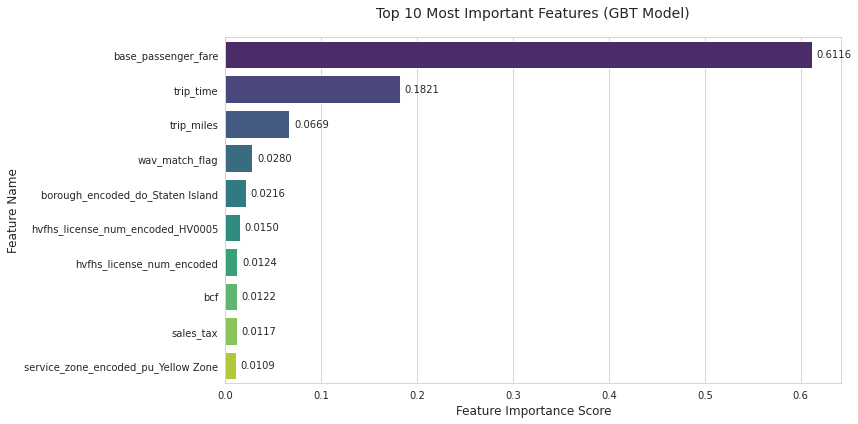

In [77]:
# Plot feature importance from GBT
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

top_10 = gbt_importance_df.head(10)

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=top_10,
    palette="viridis",
    orient="h",
)

plt.title("Top 10 Most Important Features (GBT Model)", fontsize=14, pad=20)
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)

for i, (score, name) in enumerate(zip(top_10["Importance"], top_10["Feature"])):
    ax.text(score + 0.005, i, f"{score:.4f}", va="center")

plt.tight_layout()
plt.show()

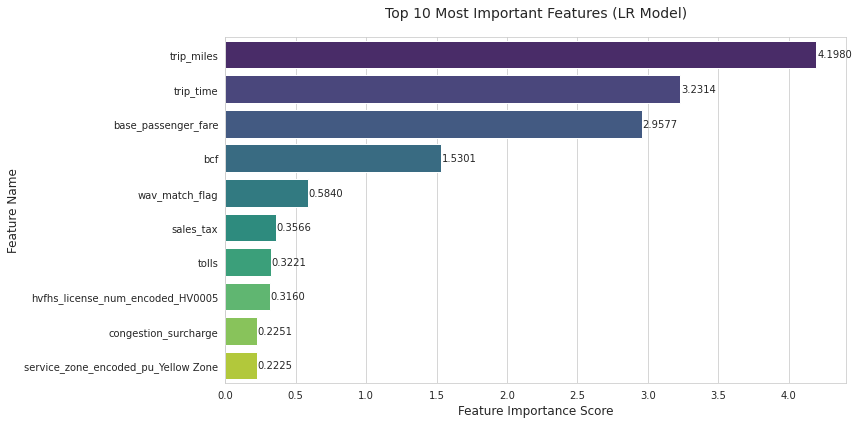

In [84]:
# Ploat feature importance from LR
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

top_10 = lr_importance_df.head(10)

ax = sns.barplot(
    x="Absolute_Coefficient",
    y="Feature",
    data=top_10,
    palette="viridis",
    orient="h",
)

plt.title("Top 10 Most Important Features (LR Model)", fontsize=14, pad=20)
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)

for i, (score, name) in enumerate(zip(top_10["Absolute_Coefficient"], top_10["Feature"])):
    ax.text(score + 0.005, i, f"{score:.4f}", va="center")

plt.tight_layout()
plt.show()

### Save the Modeling Part Results To the Database

In [8]:
# Obtain predictions
lr_predictions = spark.read.csv(
    "/user/team31/project/output/model1_predictions.csv",
    header=True,
)
gbt_predictions = spark.read.csv(
    "/user/team31/project/output/model2_predictions.csv",
    header=True,
)

In [9]:
lr_predictions.limit(10).show()

+----------+------------------+
|driver_pay|   driver_pay_pred|
+----------+------------------+
|     14.87| 10.63545254439763|
|      8.38| 6.835470936540134|
|     10.76| 5.929368363012777|
|       6.8| 5.558537527621949|
|      9.43| 6.369741552312821|
|      7.04| 4.992166254385271|
|     10.25| 6.990194691490794|
|      9.67| 9.328616810256282|
|     12.56|12.279164056192938|
|      8.92| 4.965133393545862|
+----------+------------------+



In [10]:
gbt_predictions.limit(10).show()

+----------+------------------+
|driver_pay|   driver_pay_pred|
+----------+------------------+
|     14.87| 9.571266509337274|
|      8.38| 6.330546419193481|
|     10.76| 6.286566858780703|
|       6.8| 5.954828805200265|
|      9.43| 6.202032851185389|
|      7.04| 6.042593416415323|
|     10.25| 6.158053290772612|
|      9.67| 9.323325917942858|
|     12.56|12.477610618911555|
|      8.92| 6.042593416415323|
+----------+------------------+



In [11]:
gbt_predictions.orderBy("driver_pay", ascending=False).limit(10).show()

+----------+-----------------+
|driver_pay|  driver_pay_pred|
+----------+-----------------+
|     99.97|86.59837206538789|
|     99.88|78.18337216240896|
|     99.85|80.77001453515052|
|     99.83|73.82804433721866|
|     99.81|72.52776184127765|
|     99.81|  75.927991582144|
|     99.74|85.32405743507513|
|     99.68|76.10970448637583|
|     99.65|74.00417665884731|
|     99.64| 85.3417005245112|
+----------+-----------------+



In [12]:
lr_predictions.orderBy("driver_pay", ascending=False).limit(10).show()

+----------+------------------+
|driver_pay|   driver_pay_pred|
+----------+------------------+
|     99.97| 103.6038137093002|
|     99.88|107.01347393068971|
|     99.85|101.31292861144496|
|     99.83|100.02426775127987|
|     99.81| 98.96414828360301|
|     99.81| 93.11961960920479|
|     99.74|106.37202815314477|
|     99.68| 96.74134600056081|
|     99.65|105.83604354722672|
|     99.64| 86.98687023684747|
+----------+------------------+



In [98]:
# Save both tables in Hive
lr_predictions.write.mode("overwrite").saveAsTable("team31_projectdb.model1_predictions")
gbt_predictions.write.mode("overwrite").saveAsTable("team31_projectdb.model2_predictions")

In [103]:
# Save feature importances
spark.createDataFrame(lr_importance_df).write.mode("overwrite").saveAsTable("team31_projectdb.model1_feature_importance")
spark.createDataFrame(gbt_importance_df).write.mode("overwrite").saveAsTable("team31_projectdb.model2_feature_importance")

In [104]:
# Ensure that tables are available
spark.sql("SHOW TABLES").show()

+----------------+--------------------+-----------+
|       namespace|           tableName|isTemporary|
+----------------+--------------------+-----------+
|team31_projectdb|model1_feature_im...|      false|
|team31_projectdb|  model1_predictions|      false|
|team31_projectdb|model2_feature_im...|      false|
|team31_projectdb|  model2_predictions|      false|
|team31_projectdb|          q1_results|      false|
|team31_projectdb|          q2_results|      false|
|team31_projectdb|          q3_results|      false|
|team31_projectdb|          q4_results|      false|
|team31_projectdb|          q5_results|      false|
|team31_projectdb|          q6_results|      false|
|team31_projectdb|          q7_results|      false|
|team31_projectdb|          q8_results|      false|
|team31_projectdb|          taxi_zones|      false|
|team31_projectdb|               trips|      false|
|team31_projectdb|          trips_part|      false|
|team31_projectdb|             weather|      false|
+-----------